# Using WMLA Elastic Distributed Training via API - a sample notebook

<div class="alert alert-block alert-info">


### Contents

- [The big picture](#The-big-picture)
- [Changes to your code](#Changes-to-your-code)
- [Making dataset available](#Making-dataset-available)
- [Set up API end point and log on](#Set-up-API-end-point-and-log-on)
- [Submit job via API](#Submit-job-via-API)
- [Monitor running job](#Monitor-running-job)
- [Retrieve output and saved models](#Retrieve-output-and-saved-models)
  - [Output - Retrieve training output](#Output:--Retrieve-Training-Metric)
  - [Save Models](#Save-Model)
- [Debugging any issues](#Debugging-any-issues)
- [Further information and useful links](#Further-information-and-useful-links)
- [Appendix](#Appendix)


</div>

## Introduction
[Back to top](#Contents)

This notebook details the process of performing a basic computer vision image classification example using the Deep Learning Impact functionality within Watson Machine Learning Accelerator.  

Please visit [Watson Machine Learning Accelerator Learning Path](https://developer.ibm.com/series/learning-path-get-started-with-watson-machine-learning-accelerator/) for further insight of Watson ML Accelerator

## Step 1 Download Dataset
Lets get started and download the dataset from github!!!

In [8]:
! git clone https://github.com/YoongiKim/CIFAR-10-images.git 

Cloning into 'CIFAR-10-images'...
remote: Enumerating objects: 60027, done.
remote: Total 60027 (delta 0), reused 0 (delta 0), pack-reused 60027
Receiving objects: 100% (60027/60027), 19.94 MiB | 6.17 MiB/s, done.
Resolving deltas: 100% (59990/59990), done.
Checking out files: 100% (60001/60001), done.


In [9]:
cd CIFAR-10-images/train

/Users/Kelvin/Github/wmla-assets/WMLA-learning-journey/elastic-distributed-training-module/CIFAR-10-images/train


In [10]:
import os
training_path = os.getcwd()

In [11]:
cd ../test

/Users/Kelvin/Github/wmla-assets/WMLA-learning-journey/elastic-distributed-training-module/CIFAR-10-images/test


### Copy the Dataset Training and Testing folder

In [12]:
testing_path = os.getcwd()
print ('training_path: ' + training_path)
print ('testing_path:' + testing_path)

training_path: /Users/Kelvin/Github/wmla-assets/WMLA-learning-journey/elastic-distributed-training-module/CIFAR-10-images/train
testing_path:/Users/Kelvin/Github/wmla-assets/WMLA-learning-journey/elastic-distributed-training-module/CIFAR-10-images/test


## Step 2 Import Dataset
[Back to top](#Contents)

1. At the top Left select "Workload" -> "Spark" -> "Deep Learning"
1. In the Datasets tab, select New
1. Click Images for Object Classification. When presented with a dialog box, provide a unique name (lets use "Cifar10"!!!) and select the TFRecords for 'Dataset stores images in',  and then select the folder that contains the images obtained in the previous step.  The other fields are fine to use with the default settings. When you're ready, click Create.

[](https://github.com/IBM/wmla-assets/raw/master/WMLA-learning-journey/shared-images/2_code_adaptations.png) 

![code](https://github.com/IBM/wmla-assets/raw/master/WMLA-learning-journey/shared-images/2_code_adaptations.gif)



## Step 3 Build the model

1. Select the **Models** tab and click **New**.

The key changes to your code in order to use EDT are the following:
- Importing libraries and setting up environment variables
- Data loading function for EDT
- Extract parameters for training
- Replace training and testing loops with EDT equivalents

For the purpose of this tutorial we have adapted the following RestNet18 model for use with EDT: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Please see the blog associated with this notebook with more detailed explanation of the above changes.

<span style='color:deeppink'>**TODO:** Add link to Learning Journey blog in line above</span>

You can find the original code `pytorch_mnist.py` and the updated code `pytorch_mnist_EDT.py` in the zip file `pytorch_edt.tar.gz` contained in the [tutorial repository](https://github.com/IBM/wmla-assets/raw/master/WMLA-learning-journey/elastic-distributed-training-module/pytorch_edt.tar.gz).

You can run the following command to observe relative changes:
`diff -U4 pytorch_mnist.py pytorch_mnist_EDT.py`

Your modified code should be made available in a directory which also contains the EDT helper scripts: `edtcallback.py`, `emetrics.py` and `elog.py`. Sample versions can be found in the tarball in the tutorial repository; additionally they can be downloaded from http://ibm.biz/WMLA-samples.  

## Making dataset available
[Back to top](#Contents)

Next we will make our dataset available to the WMLA cluster as seen in the diagram below. 

![data](https://github.com/IBM/wmla-assets/raw/master/WMLA-learning-journey/shared-images/3_dataset.png)

1. Ask your system admin the path of $DLI_DATA_FS directory

2. ssh to WMLA-server and get access to $DLI_DATA_FS
```


3. Download dataset

```
[WMLA-server dlidata]# wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

Resolving download.pytorch.org... 99.86.230.63, 99.86.230.94, 99.86.230.13, ...
Connecting to download.pytorch.org|99.86.230.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: 'hymenoptera_data.zip'

hymenoptera_data.zip          100%[================================================>]  45.10M  11.0MB/s    in 4.5s    

2020-02-19 17:01:52 (10.1 MB/s) - 'hymenoptera_data.zip' saved [47286322/47286322]

[WMLA-server dlidata]# unzip hymenoptera_data.zip

```

4. Unzip the zip file and modify file owner/group, that is equivalent to Instance Group Execution User (in this case it is egoadmin)
```
[WMLA-server dlidata]# chown -R egoadmin:egoadmin hymenopteradata/
[WMLA-server hymenopteradata]# pwd
/dlidata/hymenopteradata
[WMLA-server hymenopteradata]# ls -lt
total 0
drwxr-x--- 4 egoadmin egoadmin 34 Jan  7 23:54 MNIST
drwxr-xr-x 4 egoadmin egoadmin 30 Jan  7 23:08 val
drwxr-xr-x 4 egoadmin egoadmin 30 Jan  7 23:08 train
```

5. Take note of the path name of this dataset, note that your path will likely be different that seen here.
```
/dlidata/hymenopteradata
```


## Set up API end point and log on
[Back to top](#Contents)

In this section we set up the API endpoint which will be used in this notebook.

1. Source the environment

$EGO_TOP is the installation directory.  The default value is /opt/ibm/spectrumcomputing

```
. $EGO_TOP/profile.platform

```
2. Login

```
egosh user logon -u <wmla_user>
Logged on successfully

```

3. Retrieve Conductor Rest API Port

```
egosh client view |grep -A 3 ASCD_REST_BASE_URL_1
CLIENT NAME: ASCD_REST_BASE_URL_1
DESCRIPTION: http://<WMLA-server>:8280/platform/rest/

```

4.  Retrieve DLI (Deep Learning Impact) Rest API Port

```
egosh client view |grep -A 3 DLPD_REST_BASE_URL_1
CLIENT NAME: DLPD_REST_BASE_URL_1
DESCRIPTION: http://<WMLA-server>:9280/platform/rest/

```

5.  Note that the port numbers in your URL will depend on whether SSL has been enabled or not



## Submit job via API
[Back to top](#Contents)

Now we need to structure our API job submission. There are various elements to this process as seen in the diagram below. Note that **this** jupyter notebook is the one referred to below. A [static version](https://github.com/IBM/wmla-assets/raw/master/WMLA-learning-journey/shared-images/4_api_setup.png) is also available.

![code](https://github.com/IBM/wmla-assets/raw/master/WMLA-learning-journey/shared-images/4_api_setup.gif)


The following sections use the Watson ML Accelerator API to complete the various tasks required. 
We've given examples of a number of tasks but you should refer to the documentation at to see more details 
of what is possible and sample output you might expect.

- https://www.ibm.com/support/knowledgecenter/SSFHA8_1.2.1/cm/deeplearning.html
- https://www.ibm.com/support/knowledgecenter/SSZU2E_2.4.0/reference_s/api_references.html

In [1]:
import requests, json
import pandas as pd
import datetime
# from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
# plt.rcParams['figure.figsize'] = [24, 8.0]
import seaborn as sns

pd.set_option('display.max_columns', 999)
pd.set_option('max_colwidth', 300)

import tarfile
import tempfile
import os


In [4]:
#Construct API call

master_host = 'dse-ac922h.cpolab.ibm.com'


dli_rest_port = '9243'  #Deep Learning Impact Rest API Port
sc_rest_port = '8643' #Conductor Rest API Port

sc_rest_url = 'https://'+master_host+':'+sc_rest_port+'/platform/rest/conductor/v1'
dl_rest_url = 'https://'+master_host+':'+dli_rest_port+'/platform/rest/deeplearning/v1'

# User login details
wmla_user = 'Admin'
wmla_pwd = 'Admin'



myauth = (wmla_user, wmla_pwd)


# Instance Group to be used
sig_name =  'SIG-DSE-EDT'


# REST call variables
headers = {'Accept': 'application/json'}
print (sc_rest_url)
print (dl_rest_url)

# Model Path
#model_path = '<path_to_your_local_model_directory>'
model_path = '/Users/Kelvin/Github/wmla-assets/WMLA-Learning-Journey/elastic-distributed-training-module/pytorch_edt'

https://dse-ac922h.cpolab.ibm.com:8643/platform/rest/conductor/v1
https://dse-ac922h.cpolab.ibm.com:9243/platform/rest/deeplearning/v1


### Package model files for training
Package the updated model files into a tar file ending with `.modelDir.tar`

In [15]:
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))


MODEL_DIR_SUFFIX = ".modelDir.tar"
tempFile = tempfile.mktemp(MODEL_DIR_SUFFIX)
make_tarfile(tempFile, model_path)
print(" tempFile: " + tempFile)
files = {'file': open(tempFile, 'rb')}

 tempFile: /var/folders/l8/5dhpt4mn5zs6rjblzhlxp5300000gp/T/tmp6wc4pccm.modelDir.tar


### Log on


Obtain login session tokens to be used for session authentication within the RESTful API. Tokens are valid for 8 hours.

In [16]:
r = requests.get(sc_rest_url+'/auth/logon', verify=False, auth=myauth, headers=headers) 

if r.ok:
    print ('\nLogon succeeded')
    
else: 
    print('\nLogon failed with code={}, {}'. format(r.status_code, r.content))


Logon succeeded


/Users/Kelvin/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


### Check DL Frameworks details

Check what framework plugins are available and see example execution commands.  In this demonstration we will use **edtPyTorch**

In [17]:
r = requests.get(dl_rest_url+'/execs/frameworks', auth=myauth, headers=headers, verify=False).json()
# Using the raw json, easier to see the examples given
print(json.dumps(r, indent=4))

[
    {
        "name": "edtKeras",
        "description": "",
        "desc": [
            "Keras - IBM Elastic Distributed Training (EDT)",
            "Examples:",
            "$ python dlicmd.py --exec-start edtKeras <connection-options> --ig <ig> --cs-datastore-meta type=fs,data_path=mnist --model-main mnist.py"
        ]
    },
    {
        "name": "edtPyTorch",
        "description": "",
        "desc": [
            "PyTorch - IBM Elastic Distributed Training (EDT)",
            "Examples:",
            "$ python dlicmd.py --exec-start edtPyTorch <connection-options> --ig <ig> --cs-datastore-meta type=fs,data_path=mnist --model-main mnist.py"
        ]
    },
    {
        "name": "tensorflow1100",
        "description": "",
        "desc": [
            "Single-node TensorFlow. Tested for Tensorflow 1.10.0.",
            "NOTES:",
            "- Since DLI manages GPU allocation, if you explicitly assign devices using",
            "  calls such as `tf.device`, you should use

/Users/Kelvin/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


### Arguments for API call
Equivalent of flags used if running command directly on WMLA CLI, including:


In [18]:
framework_name = 'edtPyTorch' # DL Framework to use, from list given above
dataset_location = 'hymenoptera_data' # relative path of your data set under $DLI_DATA_FS
local_dir_containing_your_code = 'pytorch_edt'
number_of_GPU = '4' # number of GPUs for elastic distribution
name_of_your_code_file = 'pytorch_mnist_EDT.py' # Main model file as opened locally above


args = '--exec-start {} \
        --cs-datastore-meta type=fs,data_path={} \
        --model-dir {} \
        --edt-options maxWorkers={} \
        --model-main {} \
        --epochs 15  \
        '.format(framework_name, dataset_location, local_dir_containing_your_code, number_of_GPU, name_of_your_code_file)

print ("args: " + args)

args: --exec-start edtPyTorch         --cs-datastore-meta type=fs,data_path=hymenoptera_data         --model-dir pytorch_edt         --edt-options maxWorkers=4         --model-main pytorch_mnist_EDT.py         --epochs 15          


### Submit Job

In [19]:
r = requests.post(dl_rest_url+'/execs?sigName='+sig_name+'&args='+args, files=files,
                  auth=myauth, headers=headers, verify=False)

if r.ok:
    exec_id = r.json()['id']
    sig_id = r.json()['sigId']
    driver_id = r.json()['submissionId']
    print ('\nModel submitted successfully \Driver ID: {}'.format(driver_id))
    print ('Exec ID: {}'.format(exec_id))
    print ('SIG ID: {}'.format(sig_id))
else: 
    print('\nModel submission failed with code={}, {}'. format(r.status_code, r.content))

/Users/Kelvin/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)



Model submitted successfully \Driver ID: driver-20200330231555-0008-643aa24f-f973-4fc9-9443-a3fa1eebc065
Exec ID: Admin-11289844094804064-248509536
SIG ID: 7bbf69c0-9840-4700-bc60-37a7723e3dc6


## Monitor running job
[Back to top](#Contents)

Once the job is submitted successfully we can monitor the running job. 



In [20]:
# Check status of all RUNNING jobs in SIG (rerun cell to refresh)

monitor = []
monitor_output = []

r = requests.get(sc_rest_url+'/instances/'+sig_id+'/applications?state=RUNNING', 
                auth=myauth, headers=headers, verify=False).json()


       
if (len(r) == 0):
    print ('No jobs running')
    
else:
    
    # Filter out the relevant information
    monitor.append([(
        job['driver']['id'],
        job['driver']['state'],
        job['apprunduration'],
        job['gpuslots'],
        job['gpumemused']['total'],
        job['gpudevutil']['total'],
    ) for job in r])

    monitor_output = pd.DataFrame([item for monitor in monitor for item in monitor])
    monitor_output.columns = [
        'Driver ID', 
        'State', 
        'Run duration (mins)',
        'GPU slots',
        'Total GPU memory used',
        'Total GPU utilsation (%) ',
    ]
    
    for job in r:
        executors = job['executors']
        

monitor_output

/Users/Kelvin/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


,Driver ID,State,Run duration (mins),GPU slots,Total GPU memory used,Total GPU utilsation (%)
0,driver-20200330231555-0008-643aa24f-f973-4fc9-9443-a3fa1eebc065,RUNNING,0.297017,2,0,0.0
1,driver-20200330231500-0007-530b4f5b-92a9-40d1-a7f2-fa07084195a1,RUNNING,1.207700,2,0,0.0


## Retrieve output and saved models
[Back to top](#Contents)

After the job completes then we can retrieve the output, logs and saved models. 



### Output:  Retrieve Training Metric



In [29]:
r = requests.get(dl_rest_url+'/execs/'+exec_id+'/log', auth=myauth, headers=headers, verify=False).json()

from io import StringIO

cols = ['timestamp','global_steps','iteration','loss','accuracy']
final_data = pd.read_csv(StringIO(r.replace(':',',')), 
                 usecols=[4,6,8,10,12], 
                 names=cols)
final_data['timestamp2'] = final_data.timestamp.apply(pd.to_datetime, unit='ms')
final_data.head(10)

/Users/Kelvin/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


,timestamp,global_steps,iteration,loss,accuracy,timestamp2
0,1585624579858,1,2,0.00459,0.00750,2020-03-31 03:16:19.858
1,1585624579885,2,3,0.00463,0.00734,2020-03-31 03:16:19.885
2,1585624580434,3,4,0.00437,0.00734,2020-03-31 03:16:20.434
3,1585624580917,4,0,0.00528,0.00712,2020-03-31 03:16:20.917
4,1585624583234,5,2,0.00338,0.00681,2020-03-31 03:16:23.234
5,1585624583730,6,3,0.00285,0.00667,2020-03-31 03:16:23.730
6,1585624584214,7,4,0.00243,0.00684,2020-03-31 03:16:24.214
7,1585624584603,8,0,0.00191,0.00712,2020-03-31 03:16:24.603
8,1585624586611,9,2,-0.00207,0.00750,2020-03-31 03:16:26.611
9,1585624587046,10,3,-0.00323,0.00778,2020-03-31 03:16:27.046


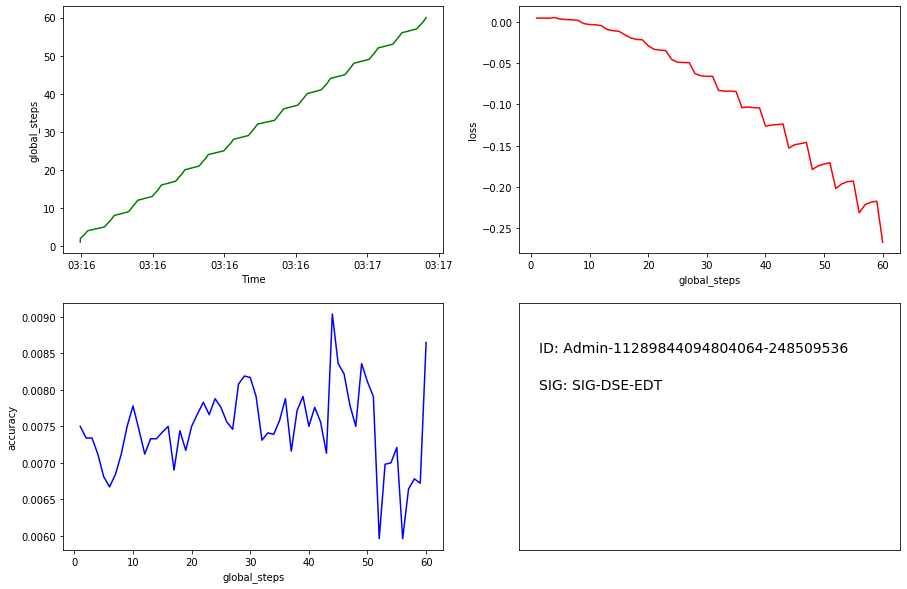

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
# plt.rcParams['figure.figsize'] = [24, 8.0]
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize = (15,10))

sns.lineplot(final_data.timestamp2,final_data.global_steps, color="g", ax=axes[0,0])
axes[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[0,0].set_xlabel("Time")

sns.lineplot(final_data.global_steps,final_data.loss, color="r", ax=axes[0,1])
sns.lineplot(final_data.global_steps,final_data.accuracy, color="b", ax=axes[1,0])

axes[1,1].axes.get_xaxis().set_visible(False)
axes[1,1].axes.get_yaxis().set_visible(False)
axes[1,1].text(0.05, 0.8, 'ID: '+exec_id, size=14)
axes[1,1].text(0.05, 0.65, 'SIG: '+sig_name, size=14)
#axes[1,1].text(0.05, 0.55, 'Status: '+status, size=14)

plt.show()

### Save Model

In [ ]:
# Get model from training job - downloads zip file (with progress bar) of saved model to directory local to this notebook
# (note that you need to save model in your code using the environment variable for location)

import requests, zipfile, io
from tqdm.notebook import tqdm

r = requests.get(dl_rest_url+'/execs/'+exec_id+'/result', auth=myauth, stream=True)

total_size = int(r.headers.get('Content-Disposition').split('size=')[1])
block_size = 1024 #1 Kibibyte
t=tqdm(total=total_size, unit='iB', unit_scale=True)

with open('model.zip', 'wb') as f:
    for data in r.iter_content(block_size):
        t.update(len(data))
        f.write(data)
t.close()

## Debugging any issues
[Back to top](#Contents)

In the case where you have issues during the process detailed above, there are a number of detailed logs that you can view to understand what is happening on the WMLA cluster.

WMLA leverages Spark architecture for distributing Deep Learning/Machine Learning jobs.  In Spark,  when an item of processing has to be done, there is a “driver” process that is in charge of taking the user’s code and converting it into a set of multiple tasks. There are also “executor” processes, each operating on a separate node in the cluster, that are in charge of running the tasks, as delegated by the driver.

You can monitor Deep Learning/Machine Learning application activity,  performance and resource usage in Driver Log & Executor Log.
- Driver Log captures issues related to dependencies and environment variable,  for example,  missing dataset or invalid execution parameter flags.
- Executor Log records Deep Learning/Machine Learning training process. 



### Retrieve Training Driver Stdout Log

In [ ]:
# Get Spectrum Conductor logs for training run - shows various information including environment variables

r = requests.get(sc_rest_url+'/instances/'+sig_id+'/applications/'+driver_id+'/logs/stdout/download',
                 auth=myauth, headers={'Accept': 'application/octet-stream'}, verify=False)

print(r.text)


Note that the output from the training can be found in the `$DLI_WORK_DIR` referenced in this log, in the directory *under* `batchworkdir`. The structure of the files contained in this directory (which you will access via the API) are the following.

```
$ tree -h
.
├── [   6]  checkpoint
├── [ 247]  log
│   ├── [   6]  0-97eb84d4-6e4b-4bb7-95e0-fc7bfda461dc.<wmla_server>
│   ├── [   6]  1-a111dd6d-c406-48f2-89ce-1ef526d5b34b.<wmla_server>
│   └── [  50]  driver-20200227104231-0007-3655c5b5-5d81-43ac-a8c6-c243635f60df.<wmla_server>
│       ├── [ 19K]  evaluation-metrics.txt
│       └── [7.1K]  stdout
├── [  19]  model
│   └── [ 214]  train
│       ├── [4.7K]  model_epoch_10_optimizer_state.pth
│       ├── [ 43M]  model_epoch_10.pth
│       ├── [4.7K]  model_epoch_5_optimizer_state.pth
│       ├── [ 43M]  model_epoch_5.pth
│       ├── [4.7K]  model_epoch_final_optimizer_state.pth
│       └── [ 43M]  model_epoch_final.pth
├── [  25]  _submitted_code
│   └── [ 133]  pytorch_edt
│       ├── [1.6K]  edtcallback.py
│       ├── [2.0K]  elog.py
│       ├── [4.1K]  emetrics.py
│       ├── [  67]  __pycache__
│       │   ├── [2.0K]  edtcallback.cpython-36.pyc
│       │   └── [2.4K]  elog.cpython-36.pyc
│       ├── [3.1K]  pytorch_mnist_EDT.py
│       └── [4.4K]  pytorch_mnist.py
└── [2.5K]  val_dict_list.json
```

### Retrieve Training Driver Stderr Log

In [ ]:
# shows various information including environment variables

r = requests.get(sc_rest_url+'/instances/'+sig_id+'/applications/'+driver_id+'/logs/stderr/download',
                 auth=myauth, headers={'Accept': 'application/octet-stream'}, verify=False)

print(r.text)

### Retrieve Training Executor Log
#### Retrieve Executor ID
- The deep learning training log per GPU is written in executor log
- Execute following code to retrieve list of executor ID

In [ ]:
for key in executors:    
    print ('executors: ' + key['id'])

### Retrieve Executor Stdout log
- set the parameter executor_id

In [ ]:
executor_id = '1-a5c6d934-df3d-4b3e-8a9d-87ee8d168910'

r = requests.get(sc_rest_url+'/instances/'+sig_id+'/applications/'+driver_id +'/'+executor_id+'/logs/stdout/download',
                 auth=myauth, headers={'Accept': 'application/octet-stream'}, verify=False)

print(r.text)



### Retrieve Executor Stderr log
- set the parameter executor_id

In [ ]:
executor_id = '1-a5c6d934-df3d-4b3e-8a9d-87ee8d168910'

r = requests.get(sc_rest_url+'/instances/'+sig_id+'/applications/'+driver_id +'/'+executor_id+'/logs/stderr/download',
                 auth=myauth, headers={'Accept': 'application/octet-stream'}, verify=False)

print(r.text)

## Further information and useful links
[Back to top](#Contents)

**WMLA Introductory videos:**
- WMLA overview video (6 mins): http://ibm.biz/WMLA-video
- WMLA getting started (3 mins): http://ibm.biz/WMLA-start
- Overview of adapting your code for Elastic Distributed Training via API: [video](https://youtu.be/RnZtYNX6meM) | [PDF](docs/wmla_api_pieces.pdf) (screenshot below)

**Further WMLA information & documentation**
- [Power Developer Portal (WMLCE frameworks information)](https://developer.ibm.com/linuxonpower/deep-learning-powerai/releases/)
- WMLA tutorials: http://ibm.biz/WMLA-blog
- Knowledge Centre links:
  - [IBM Watson Machine Learning Accelerator](https://www.ibm.com/support/knowledgecenter/SSFHA8)
  - [IBM Spectrum Conductor](https://www.ibm.com/support/knowledgecenter/en/SSZU2E/product_welcome_conductorspark.html)
  - [IBM Spectrum Conductor Deep Learning Impact](https://www.ibm.com/support/knowledgecenter/SSWQ2D)

**Further Power Systems information**
- [AI on Power Systems Redbook (PDF)](https://www.redbooks.ibm.com/redbooks/pdfs/sg248435.pdf) (deep dive technical information)

## Appendix
[Back to top](#Contents)

#### This notebook requires Watson ML Accelerator 1.2.1 + Interim Fix 527174 & 536919 to run.
For details please refer to following link:
https://www.ibm.com/support/knowledgecenter/en/SSFHA8_1.2.1/wmla_fix_pack.html

#### This is version 1.0 and its content is copyright of IBM.   All rights reserved.   


